In [2]:
import numpy as np
import seaborn as sns
from scipy.stats import dirichlet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
from sklearn.preprocessing import LabelEncoder

## **Utils**

In [90]:
# Plotting Functions
def plot_persistence_probabilities(xi_draws, H, K):
    """
    Plots scatter plots of the persistence probabilities for Markov chain clustering.
    """
    num_draws = len(xi_draws)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Scatter Plots of Persistence Probabilities", fontsize=16)

    titles = [
        r"$(\xi_{h,00}, \xi_{h,11})$",
        r"$(\xi_{h,00}, \xi_{h,22})$",
        r"$(\xi_{h,11}, \xi_{h,22})$"
    ]

    for h in range(H):
        xi_h = np.array([xi_draws[i][h] for i in range(num_draws)])  # Shape: (num_draws, K, K)

        axes[0].scatter(xi_h[:, 0, 0], xi_h[:, 1, 1], alpha=0.5, label=f"Cluster {h+1}")
        axes[1].scatter(xi_h[:, 0, 0], xi_h[:, 2, 2], alpha=0.5, label=f"Cluster {h+1}")
        axes[2].scatter(xi_h[:, 1, 1], xi_h[:, 2, 2], alpha=0.5, label=f"Cluster {h+1}")

    for i in range(3):
        axes[i].set_title(titles[i], fontsize=14)
        axes[i].set_xlabel(r"$\xi_{h,00}$", fontsize=12)
        axes[i].set_ylabel(r"$\xi_{h,11}$" if i == 0 else r"$\xi_{h,22}$", fontsize=12)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def create_transition_matrix_table(xi_draws):
    """
    Creates a table showing the posterior expectation and standard deviations of the transition matrices.
    """
    num_draws = len(xi_draws)
    H = len(xi_draws[0])  # Number of clusters
    K = xi_draws[0][0].shape[0]  # Number of states

    xi_mean = np.mean(xi_draws, axis=0)  # Shape: (H, K, K)
    xi_std = np.std(xi_draws, axis=0) * 100  # Shape: (H, K, K), scaled by 100

    table = []
    for h in range(H):
        for j in range(K):
            row = []
            for k in range(K):
                value = f"{xi_mean[h, j, k]:.3f} ({xi_std[h, j, k]:.1f})"
                row.append(value)
            table.append(row)

    columns = [f"To State {k+1}" for k in range(K)]
    index = pd.MultiIndex.from_product(
        [[f"Cluster {h+1}" for h in range(H)], [f"From State {j+1}" for j in range(K)]],
        names=["Cluster", "From State"]
    )
    df = pd.DataFrame(table, columns=columns, index=index)

    return df

def plot_transition_matrices(xi_mean, eta_mean):
    """
    Visualizes the posterior expectation of the transition matrices using circular areas.
    """
    H, K, _ = xi_mean.shape  # Number of clusters and states
    fig, axes = plt.subplots(1, H, figsize=(5 * H, 5))
    if H == 1:
        axes = [axes]  # Ensure axes is a list for consistency

    for h in range(H):
        ax = axes[h]
        ax.set_title(f"Cluster {h+1} (η={eta_mean[h]:.2f})", fontsize=14)
        ax.set_xlim(-0.5, K - 0.5)
        ax.set_ylim(-0.5, K - 0.5)
        ax.set_xticks(np.arange(K))
        ax.set_yticks(np.arange(K))
        ax.set_xticklabels([f"State {k+1}" for k in range(K)], fontsize=12)
        ax.set_yticklabels([f"State {k+1}" for k in range(K)], fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.7)

        for j in range(K):
            for k in range(K):
                circle = plt.Circle(
                    (k, K - 1 - j),  # Invert y-axis for better visualization
                    radius=xi_mean[h, j, k] * 0.4,  # Scale radius by transition probability
                    color="blue",
                    alpha=0.6,
                )
                ax.add_patch(circle)
                ax.text(
                    k,
                    K - 1 - j,
                    f"{xi_mean[h, j, k]:.2f}",
                    ha="center",
                    va="center",
                    fontsize=12,
                    color="white",
                )

    plt.tight_layout()
    plt.show()

def compute_empirical_pi_t(y, S, H, K, max_t):
    """
    Computes the empirical distribution π_{h,t} over states at time t for each cluster,
    accounting for varying time series lengths.

    Parameters:
    - y: List of time series data for each individual.
    - S: Cluster assignments for each individual.
    - H: Number of clusters.
    - K: Number of states.
    - max_t: Maximum number of time steps to compute.

    Returns:
    - pi_t_empirical: Empirical distribution π_{h,t}, shape (H, max_t, K).
    """
    pi_t_empirical = np.zeros((H, max_t, K))  # Shape: (H, max_t, K)

    for h in range(H):
        # Filter individuals in cluster h
        cluster_indices = np.where(S == h)[0]

        for t in range(max_t):
            # Count the number of individuals with data at time t
            num_individuals_at_t = 0
            state_counts = np.zeros(K)

            for i in cluster_indices:
                if t < len(y[i]):  # Check if individual i has data at time t
                    num_individuals_at_t += 1
                    state = y[i][t]
                    state_counts[state] += 1

            # Normalize to get probabilities (only if there are individuals with data at time t)
            if num_individuals_at_t > 0:
                pi_t_empirical[h, t] = state_counts / num_individuals_at_t

    return pi_t_empirical

def plot_empirical_stacked_histograms(pi_t_empirical, H, K, max_t):
    """
    Plots stacked histograms for the empirical distribution π_{h,t} over states at time t.

    Parameters:
    - pi_t_empirical: Empirical distribution π_{h,t}, shape (H, max_t, K).
    - H: Number of clusters.
    - K: Number of states.
    - max_t: Maximum number of time steps to plot.
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(H, 1, figsize=(10, 5 * H))
    if H == 1:
        axes = [axes]  # Ensure axes is a list for consistency

    # Define time steps
    time_steps = np.arange(1, max_t + 1)

    # Plot for each cluster
    for h in range(H):
        ax = axes[h]
        pi_t_values = pi_t_empirical[h]  # Shape: (max_t, K)

        # Plot stacked histograms
        bottom = np.zeros(max_t)
        for k in range(K):
            ax.bar(time_steps, pi_t_values[:, k], bottom=bottom, label=f"State {k + 1}")
            bottom += pi_t_values[:, k]

        # Customize the plot
        ax.set_title(f"Cluster {h + 1}", fontsize=14)
        ax.set_xlabel("Time Steps (t)", fontsize=12)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_xticks(time_steps)
        ax.legend(loc="upper right")
        ax.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


## **Markov chain clustering**

The implementation is based on the following formulas:

1. **Bayes’ Classification for Each Individual**:
   - Formula: $ Pr(S_i = h|y_i, \eta, \vartheta_1, \ldots, \vartheta_H) \propto p(y_i|\vartheta_h)\eta_h $
   - Explanation: This formula is used to classify each individual $ i $ into one of the $ H $ clusters. The probability that individual $ i $ belongs to cluster $ h $ is proportional to the likelihood of the data $ y_i $ given the cluster parameters $ \vartheta_h $ and the mixing proportion $ \eta_h $.

2. **Sampling Mixing Proportions**:
   - Formula: $ \eta \sim D(\alpha_1, \ldots, \alpha_H) $ where $
    \alpha_h = \#\{S_i = h\} + \alpha_0 $
   - Explanation: The mixing proportions \( \eta \) are sampled from a Dirichlet distribution. The parameters \( \alpha_h \) are updated based on the number of individuals classified into each cluster $ h $.

3. **Sampling Component Parameters**:
   - Formula: $ \vartheta_h \sim p(\vartheta_h|S, y) $
   - Explanation: The component parameters $ \vartheta_h $ (in this case, the transition matrices $ \xi_h $) are sampled from their posterior distribution given the classifications \( S \) and the data $ y $.

4. **Posterior Distribution for Transition Matrices**:
   - Formula: $ p(\xi_1, \ldots, \xi_H|S, y) \propto \prod_{h=1}^{H} \prod_{j=1}^{K} \left( \prod_{k=1}^{K} (\xi_{h,j,k})^{N_{j,k}^h + e_0,j_k - 1} \right) $
   - Explanation: The posterior distribution of the transition matrices $ \xi_h $ is proportional to the product of the likelihood of the data and the prior distribution. The counts \( N_{j,k}^h $ represent the number of transitions from state $ j $ to state $ k $ in cluster $ h $.

5. **Dirichlet Distribution for Sampling Transition Matrices**:
   - Formula: $ \xi_{h,j} |S, y \sim D(e_0,j_1 + N_{j_1}^h, \ldots, e_0,j_K + N_{j_K}^h) $
   - Explanation: Each row $ \xi_{h,j} $ of the transition matrix $ \xi_h $ is sampled from a Dirichlet distribution with parameters updated by the observed transition counts $ N_{j,k}^h $.

In [91]:
# Data Simulation
class DataSimulator:
    def __init__(self, K, H, N, min_T, max_T):
        self.K = K  # Number of states
        self.H = H  # Number of clusters
        self.N = N  # Number of individuals
        self.min_T = min_T  # Minimum length of time series
        self.max_T = max_T  # Maximum length of time series

    def simulate_time_series(self, xi, T):
        y = np.zeros(T, dtype=int)
        y[0] = np.random.choice(self.K)  # Initial state
        for t in range(1, T):
            y[t] = np.random.choice(self.K, p=xi[y[t-1]])
        return y

    def simulate_data(self, true_xi):
        self.true_S = np.random.randint(0, self.H, size=self.N)
        self.y = []
        for i in range(self.N):
            T = np.random.randint(self.min_T, self.max_T + 1)  # Random length for each time series
            h = self.true_S[i]
            self.y.append(self.simulate_time_series(true_xi[h], T))
        return self.y, self.true_S

# Markov Chain Clustering
class MarkovChainClustering:
    def __init__(self, K, H, N, e0):
        self.K = K  # Number of states
        self.H = H  # Number of clusters
        self.N = N  # Number of individuals
        self.e0 = e0  # Prior parameters for transition matrices

    def calculate_transition_counts(self, y, S):
        N_jk = np.zeros((self.H, self.K, self.K))
        for i in range(self.N):
            h = S[i]
            for t in range(1, len(y[i])):
                j = y[i][t-1]
                k = y[i][t]
                N_jk[h, j, k] += 1
        return N_jk

    def gibbs_sampling(self, y, num_iterations=1000):
        S = np.random.randint(0, self.H, size=self.N)
        xi = [np.random.dirichlet(self.e0[j], size=self.K) for j in range(self.H)]
        eta = np.ones(self.H) / self.H  # Initialize mixing proportions

        xi_draws = []  # Store MCMC draws of transition matrices
        eta_draws = []  # Store MCMC draws of mixing proportions

        for iteration in range(num_iterations):
            # Step 1: Classify each individual
            for i in range(self.N):
                probs = np.zeros(self.H)
                for h in range(self.H):
                    likelihood = 1.0
                    for t in range(1, len(y[i])):
                        j = y[i][t-1]
                        k = y[i][t]
                        likelihood *= xi[h][j, k]
                    probs[h] = likelihood * eta[h]
                probs /= probs.sum()  # Normalize
                S[i] = np.random.choice(self.H, p=probs)
            
            # Step 2: Sample mixing proportions
            alpha = np.array([np.sum(S == h) + 1 for h in range(self.H)])  # Dirichlet parameters
            eta = dirichlet.rvs(alpha)[0]
            eta_draws.append(eta)
            
            # Step 3: Sample component parameters
            N_jk = self.calculate_transition_counts(y, S)
            for h in range(self.H):
                for j in range(self.K):
                    xi[h][j] = dirichlet.rvs(self.e0[j] + N_jk[h, j])[0]
            xi_draws.append([xi[h].copy() for h in range(self.H)])  # Store a copy of xi
        
        return S, xi_draws, eta_draws

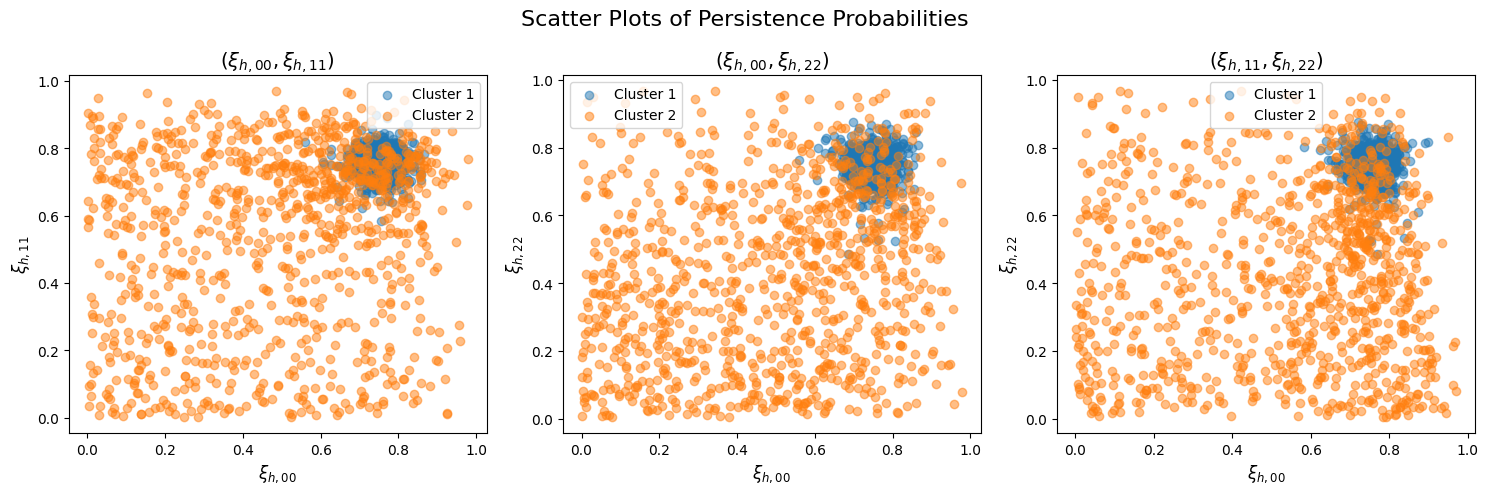

Posterior Expectation and Standard Deviations of Transition Matrices:
                          To State 1    To State 2    To State 3
Cluster   From State                                            
Cluster 1 From State 1   0.751 (3.6)   0.128 (2.9)   0.121 (2.7)
          From State 2   0.111 (3.1)   0.760 (3.4)   0.129 (3.4)
          From State 3   0.096 (2.4)   0.157 (4.0)   0.747 (4.1)
Cluster 2 From State 1  0.490 (26.0)  0.252 (19.5)  0.258 (22.0)
          From State 2  0.258 (20.6)  0.540 (26.8)  0.202 (20.0)
          From State 3  0.237 (20.3)  0.339 (23.4)  0.425 (25.2)


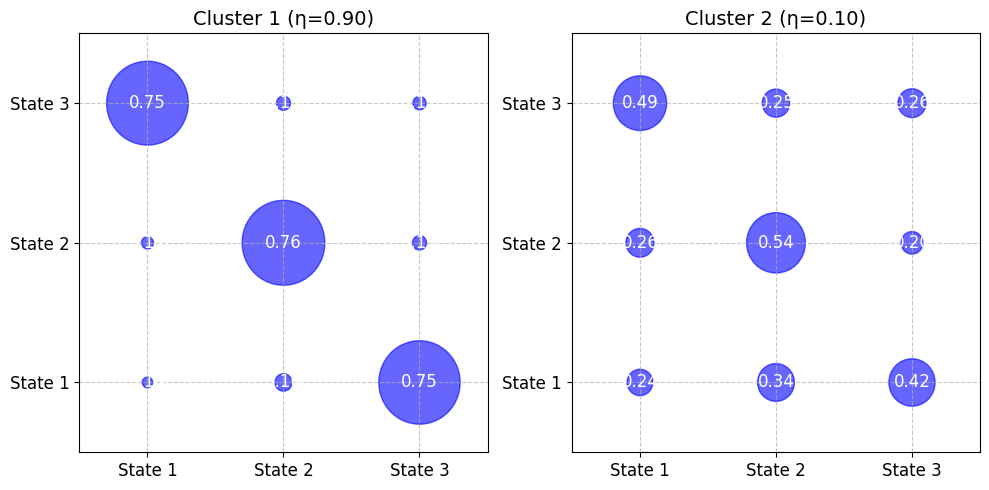

In [92]:
# Testing on synthetic data
# Parameters
K = 3  # Number of states
H = 2  # Number of clusters
N = 100  # Number of individuals
min_T = 5  # Minimum length of time series
max_T = 10  # Maximum length of time series
e0 = np.ones((K, K))  # Prior parameters for transition matrices

# Simulate true transition matrices
true_xi = [np.array([[0.7, 0.2, 0.1], [0.1, 0.7, 0.2], [0.1, 0.1, 0.8]]),
            np.array([[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.1, 0.2, 0.7]])]

# Simulate data
data_simulator = DataSimulator(K, H, N, min_T, max_T)
y, true_S = data_simulator.simulate_data(true_xi)

# Perform clustering
mcc = MarkovChainClustering(K, H, N, e0)
S, xi_draws, eta_draws = mcc.gibbs_sampling(y)

# Compute posterior expectations
xi_mean = np.mean(xi_draws, axis=0)  # Shape: (H, K, K)
eta_mean = np.mean(eta_draws, axis=0)  # Shape: (H,)

# Plot persistence probabilities
plot_persistence_probabilities(xi_draws, H, K)

# Create and display the transition matrix table
table = create_transition_matrix_table(xi_draws)
print("Posterior Expectation and Standard Deviations of Transition Matrices:")
print(table)

# Plot transition matrices
plot_transition_matrices(xi_mean, eta_mean)

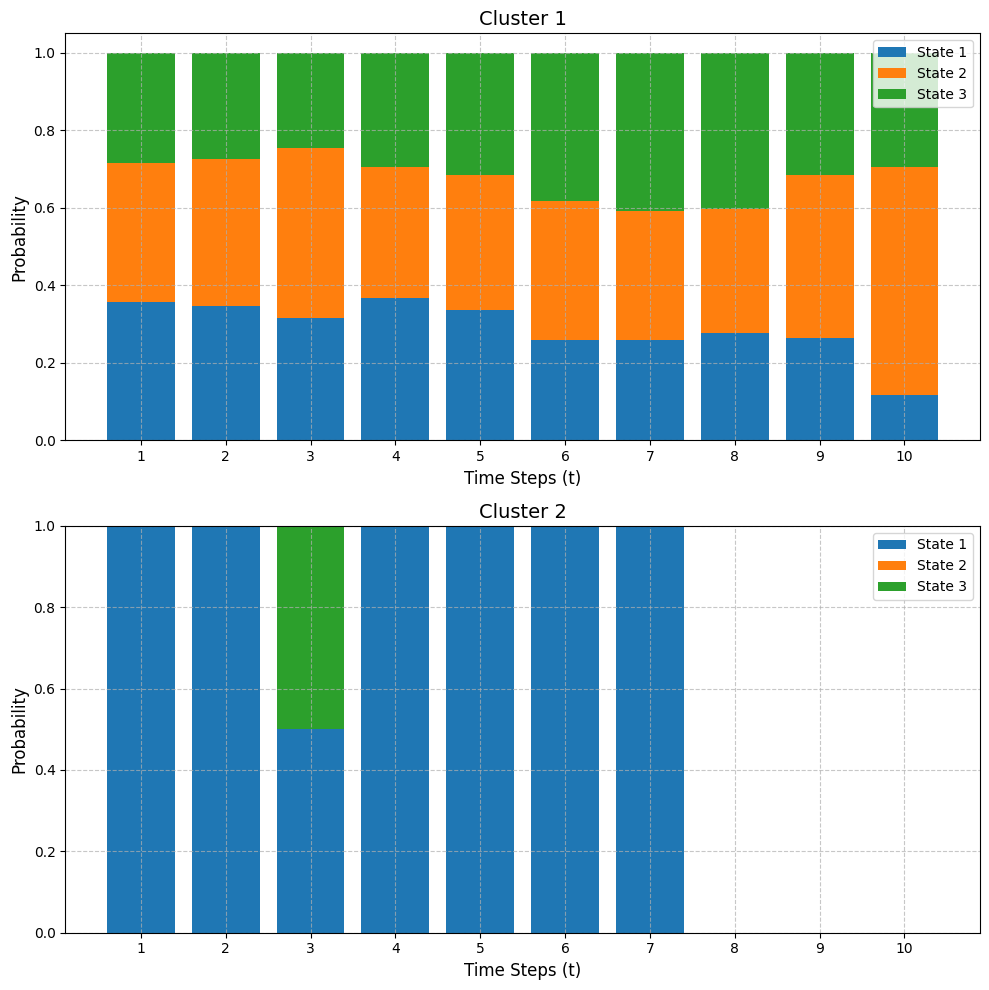

In [93]:
# Compute empirical π_{h,t}
max_t = 10  # Maximum number of time steps to compute
pi_t_empirical = compute_empirical_pi_t(y, S, H, K, max_t)

# Plot empirical stacked histograms
plot_empirical_stacked_histograms(pi_t_empirical, H, K, max_t)

## **Dirichlet Multinomial Clustering**

### **Introducing Dirichlet Multinomial Clustering**

Below, I will explain the **key formulas** used in the algorithm.

#### 1. Dirichlet-Multinomial Model
The model assumes that the data is generated from a mixture of multinomial distributions, where each cluster has its own set of parameters. The key components are:

- **Cluster Assignments ($S_i$)**: Each individual $i$ is assigned to a cluster $h$ based on the posterior probability:
  $$
  \Pr(S_i = h | y_i, \eta, \theta_1, \dots, \theta_H) \propto p(y_i | \theta_h) \eta_h,
  $$
  where:
  - $y_i$ is the observed time series for individual $i$.
  - $\eta_h$ is the mixing proportion for cluster $h$.
  - $\theta_h$ represents the group-specific parameters for cluster $h$.

- **Mixing Proportions ($\eta$)**: The mixing proportions are sampled from a Dirichlet distribution:
  $$
  \eta \sim \text{Dirichlet}(\alpha_1, \dots, \alpha_H),
  $$
  where $\alpha_h = \#\{S_i = h\} + \alpha_0$, and $\alpha_0$ is a hyperparameter.

- **Group-Specific Parameters ($\theta_h$)**: The parameters $\theta_h$ are sampled from their posterior distribution:
  $$
  p(\theta_h | S, y) \propto p(y | \theta_h) p(\theta_h),
  $$
  where $p(\theta_h)$ is the prior distribution for $\theta_h$.

---

#### 2. Negative Multinomial Distribution
For the group-specific parameters $\theta_h$, the code assumes that the rows of the transition matrix $e_{h,j\cdot}$ follow a **negative multinomial distribution**:
$$
e_{h,j\cdot} - 1 \sim \text{NegMulNom}(p_{j1}, \dots, p_{jK}, \beta),
$$
where:
- $p_{jk} = \frac{N_0 \hat{\xi}_{jk}}{\alpha + N_0}$ is the probability of transitioning from state $j$ to state $k$.
- $\beta$ is a hyperparameter.
- $N_0$ is the size of an imaginary experiment (e.g., $N_0 = 10$).

The **prior density** for $e_{h,j\cdot}$ is given by:
$$
p(e_{h,j\cdot}) = \frac{\Gamma(\beta - K + \sum_{k=1}^K e_{h,jk})}{\Gamma(\beta) \prod_{k=1}^K (e_{h,jk} - 1)!} \cdot p_{j0}^\beta \prod_{k=1}^K p_{jk}^{e_{h,jk} - 1},
$$
where $p_{j0} = 1 - \sum_{k=1}^K p_{jk}$.

---

#### 3. Posterior Distribution for $e_{h,j\cdot}$
The posterior distribution for $e_{h,j\cdot}$ is derived from the complete-data likelihood:
$$
p(e_{h,j\cdot} | y, S) \propto p(y | e_{h,j\cdot}) p(e_{h,j\cdot}),
$$
where:
- $p(y | e_{h,j\cdot})$ is the likelihood of the data given the parameters.
- $p(e_{h,j\cdot})$ is the prior distribution.

The **log posterior** is computed as:
$$
\log p(e_{h,j\cdot} | y, S) = \log p(e_{h,j\cdot}) + \sum_{i: S_i = h} \log p(y_i | e_{h,j\cdot}).
$$

---

#### 4. Metropolis-Hastings Algorithm
To sample $e_{h,j\cdot}$ from its posterior distribution, the code uses a **Metropolis-Hastings algorithm**:
1. Propose a new value $e_{h,j\cdot}^\text{new}$ from a discrete random walk proposal distribution.
2. Compute the acceptance probability:
   $$
   r = \frac{p(e_{h,j\cdot}^\text{new} | y, S) \cdot q(e_{h,j\cdot}^\text{old} | e_{h,j\cdot}^\text{new})}{p(e_{h,j\cdot}^\text{old} | y, S) \cdot q(e_{h,j\cdot}^\text{new} | e_{h,j\cdot}^\text{old})},
   $$
   where $q(\cdot)$ is the proposal distribution.
3. Accept the new value with probability $\min(1, r)$.

### **Comparison between Dirichlet Multinomial Clustering and  Markov Chain Clustering**

The two methods, **Markov Chain Clustering** and **Dirichlet Multinomial Clustering**, differ in their modeling assumptions and computational approaches. Here's a breakdown of the key differences:

---

#### **1. Modeling Assumptions**

##### **Markov Chain Clustering**:
- Assumes that the transition matrices $\xi_h$ for each cluster $h$ follow a **Dirichlet distribution**.
- The rows of the transition matrix $\xi_h$ are assumed to be independent and follow a Dirichlet distribution, which allows for conjugate priors and straightforward Gibbs sampling.
- The likelihood is based on the **Markov property**, where the probability of transitioning to the next state depends only on the current state.

##### **Dirichlet Multinomial Clustering**:
- Assumes that the group-specific parameters $e_{h,j}$ follow a **negative multinomial distribution**.
- The rows of $e_{h,j}$ are modeled as discrete-valued multivariate random variables, which introduces dependencies between the elements of each row.
- The likelihood is based on the **Dirichlet multinomial distribution**, which generalizes the multinomial distribution by allowing for overdispersion (i.e., more variability than a standard multinomial distribution).

---

#### **2. Computational Approach**

##### **Markov Chain Clustering**:
- Uses **Gibbs sampling** to sample the transition matrices $\xi_h$ and the cluster assignments $S$.
- The conjugate prior (Dirichlet distribution) allows for straightforward updates of the transition matrices.

##### **Dirichlet Multinomial Clustering**:
- Uses a **Metropolis-Hastings algorithm** to sample the group-specific parameters $e_{h,j}$.
- The posterior distribution $p(e_{h,j} | y, S)$ is not of closed form, so a Metropolis-Hastings step is required.
- The algorithm avoids sampling individual transition matrices $\xi_i$ for each time series, which would be computationally expensive.

---

#### **3. Handling of Heterogeneity**

##### **Markov Chain Clustering**:
- Assumes homogeneity within clusters, meaning all individuals in a cluster share the same transition matrix $\xi_h$.

##### **Dirichlet Multinomial Clustering**:
- Allows for heterogeneity within clusters by modeling the group-specific parameters $e_{h,j}$ as random variables.
- This approach captures more variability in the data, making it suitable for datasets with overdispersion.

---

#### **Summary of Differences**

| Aspect                  | Markov Chain Clustering                          | Dirichlet Multinomial Clustering                  |
|-------------------------|--------------------------------------------------|--------------------------------------------------|
| **Modeling Assumptions** | Transition matrices follow a Dirichlet distribution. | Group-specific parameters follow a negative multinomial distribution. |
| **Computational Approach** | Uses Gibbs sampling with conjugate priors.       | Uses Metropolis-Hastings for non-conjugate posteriors. |
| **Handling of Heterogeneity** | Assumes homogeneity within clusters.             | Allows for heterogeneity within clusters.        |

---

#### **Conclusion**
- **Markov Chain Clustering** is simpler and more efficient for datasets where homogeneity within clusters can be assumed.
- **Dirichlet Multinomial Clustering** is more flexible and better suited for datasets with overdispersion or heterogeneity within clusters.

Let me know if you need further clarification or additional analysis!

In [94]:
class DirichletMultinomialClustering:
    def __init__(self, K, H, alpha=1, beta=1, N0=10):
        self.K = K  # Number of states
        self.H = H  # Number of clusters
        self.alpha = alpha  # Hyperparameter for prior
        self.beta = beta  # Hyperparameter for prior
        self.N0 = N0  # Size of imaginary experiment

    def compute_transition_counts(self, y, S):
        """
        Computes the transition counts N_{i,j,k} for each individual.
        """
        N_jk = np.zeros((self.N, self.K, self.K))
        for i in range(self.N):
            for t in range(1, len(y[i])):
                j = y[i][t-1]
                k = y[i][t]
                N_jk[i, j, k] += 1
        return N_jk

    def log_posterior_e(self, e_hj, N_hj, N_h):
        """
        Computes the log posterior for e_{h,j}.
        """
        log_prior = gammaln(np.sum(e_hj)) - np.sum(gammaln(e_hj))
        log_likelihood = np.sum(gammaln(N_hj + e_hj)) - gammaln(np.sum(N_hj + e_hj))
        return log_prior + log_likelihood

    def metropolis_hastings_step(self, e_hj, N_hj, N_h):
        """
        Performs a Metropolis-Hastings step to update e_{h,j}.
        """
        # Propose new values
        e_new = e_hj.copy()
        for k in range(self.K):
            if e_hj[k] >= 2:
                e_new[k] += np.random.choice([-1, 0, 1])
            elif e_hj[k] == 1:
                e_new[k] += np.random.choice([0, 1])
            e_new[k] = max(1, e_new[k])  # Ensure e_new[k] >= 1

        # Compute acceptance probability
        log_r = self.log_posterior_e(e_new, N_hj, N_h) - self.log_posterior_e(e_hj, N_hj, N_h)
        if np.log(np.random.rand()) < log_r:
            return e_new
        else:
            return e_hj

    def gibbs_sampling(self, y, num_iterations=1000):
        """
        Performs Gibbs sampling for Dirichlet Multinomial Clustering.
        Returns:
        - S: Cluster assignments.
        - e_draws: Posterior samples of e_{h,j}.
        """
        self.N = len(y)  # Number of individuals
        # Initialize cluster assignments and parameters
        S = np.random.randint(0, self.H, size=self.N)
        e = np.ones((self.H, self.K, self.K))  # Initialize e_{h,j,k}

        # Compute transition counts
        N_jk = self.compute_transition_counts(y, S)

        # Store posterior samples of e
        e_draws = []

        for iteration in range(num_iterations):
            # Step 1: Update cluster assignments S
            for i in range(self.N):
                log_probs = np.zeros(self.H)
                for h in range(self.H):
                    log_likelihood = 0
                    for j in range(self.K):
                        for k in range(self.K):
                            log_likelihood += gammaln(N_jk[i, j, k] + e[h, j, k]) - gammaln(e[h, j, k])
                    log_probs[h] = log_likelihood
                log_probs -= log_probs.max()  # Normalize for numerical stability
                probs = np.exp(log_probs)
                probs /= probs.sum()
                S[i] = np.random.choice(self.H, p=probs)

            # Step 2: Update group-specific parameters e_{h,j}
            for h in range(self.H):
                for j in range(self.K):
                    N_hj = N_jk[S == h, j, :].sum(axis=0)
                    N_h = (S == h).sum()
                    e[h, j] = self.metropolis_hastings_step(e[h, j], N_hj, N_h)

            # Store the current value of e
            e_draws.append(e.copy())

        return S, e_draws

def compute_transition_matrix(e):
    """
    Computes the transition matrix xi_h for each cluster h.
    """
    H, K, _ = e.shape
    xi = np.zeros((H, K, K))
    for h in range(H):
        for j in range(K):
            xi[h, j] = e[h, j] / np.sum(e[h, j])
    return xi

def plot_transition_matrix(xi, cluster_labels):
    """
    Plots the transition matrix as a heatmap for each cluster.
    """
    H, K, _ = xi.shape
    fig, axes = plt.subplots(1, H, figsize=(5 * H, 5))
    if H == 1:
        axes = [axes]  # Ensure axes is a list for consistency

    for h in range(H):
        ax = axes[h]
        sns.heatmap(xi[h], annot=True, fmt=".2f", cmap="YlGnBu", ax=ax,
                    xticklabels=cluster_labels, yticklabels=cluster_labels)
        ax.set_title(f"Cluster {h+1}", fontsize=14)
        ax.set_xlabel("To State", fontsize=12)
        ax.set_ylabel("From State", fontsize=12)

    plt.tight_layout()
    plt.show()

# Load real data (example: categorical time series)
# Replace this with your real dataset
data = [
    [0, 1, 0, 2, 1],  # Individual 1
    [1, 2, 1, 0, 2],  # Individual 2
    [0, 0, 1, 2, 0],  # Individual 3
    [2, 1, 0, 1, 2],  # Individual 4
    # Add more individuals as needed
]

# Encode categorical states as integers
label_encoder = LabelEncoder()
data_encoded = [label_encoder.fit_transform(seq) for seq in data]
K = len(label_encoder.classes_)  # Number of states
cluster_labels = label_encoder.classes_  # State labels

# Perform clustering
H = 2  # Number of clusters
dmc = DirichletMultinomialClustering(K, H)
S, e_draws = dmc.gibbs_sampling(data_encoded, num_iterations=1000)

# Compute posterior expectation of e
e_mean = np.mean(e_draws, axis=0)

# Compute transition matrix xi
xi = compute_transition_matrix(e_mean)

## **Testing on real data**

### **Experiment Description and Goal of the Protocol on Real Data**

The goal of this experiment is to apply the **Markov Chain Clustering** model to a real-world dataset to uncover patterns in customer behavior over time. Specifically, we aim to:

1. **Cluster Customers**: Group customers into distinct clusters based on their purchasing behavior over time.
2. **Model Behavior**: Estimate the transition probabilities between different states (e.g., spending categories) for each cluster.
3. **Analyze Trends**: Understand how customers transition between spending categories (e.g., "Low", "Medium", "High", "Very High") and identify differences in behavior across clusters.

The real-world dataset used in this experiment is an **Online Retail Customer Segmentation** dataset, which contains transactional data, including customer IDs, invoice dates, quantities, and unit prices.

---

#### **Protocol Steps**

**1. Data Loading and Preprocessing**
The dataset is loaded and preprocessed to prepare it for analysis. The preprocessing steps include:
- **Handling Dates**: Extract the month and year from the `InvoiceDate` column.
- **Aggregating Data**: Aggregate transactions by `CustomerID` and `InvoiceMonth` to calculate the total monetary value spent by each customer in each month.
- **Categorizing Spending**: Categorize the total monetary value into four categories ("Low", "Medium", "High", "Very High") using quantiles.
- **Handling Missing Data**: Fill missing values in the `MonetaryCategory` column with "Low".
- **Creating Time Series**: Convert the data into a time series format, where each customer's spending behavior over time is represented as a sequence of spending categories.

**2. Clustering Using Markov Chain Model**
The preprocessed data is then used to perform clustering using the **Markov Chain Clustering** algorithm. The steps include:
- **Initialization**: Define the number of states (`K = 4`) and clusters (`H = 2`).
- **Gibbs Sampling**: Use Gibbs sampling to estimate the posterior distributions of the transition matrices (`xi_draws`) and mixing proportions (`eta_draws`).
- **Posterior Expectations**: Compute the posterior expectations of the transition matrices (`xi_mean`) and mixing proportions (`eta_mean`).

**2bis. Clustering Using Dirichlet Multinomial Model**
The preprocessed data is then used to perform clustering using the **Dirichlet Multinomial Clustering** algorithm. The steps include:

- **Initialization**: Define the number of states ($K = 4$) and clusters ($H = 2$), and set hyperparameters for the Dirichlet prior ($\alpha$, $\beta$, and $N_0$).

- **Gibbs Sampling**: Use Gibbs sampling to estimate the posterior distributions of the group-specific parameters ($e_{\text{draws}}$) and mixing proportions ($\eta_{\text{draws}}$). The sampling involves:
  - **Cluster Assignments**: Assign each individual to a cluster based on the posterior probability of belonging to each cluster.
  - **Parameter Updates**: Update the group-specific parameters ($e_{h,jk}$) using a Metropolis-Hastings step to sample from their posterior distributions.

- **Posterior Expectations**: Compute the posterior expectations of the transition matrices ($\xi_{\text{mean}}$) and mixing proportions ($\eta_{\text{mean}}$), where:
  - The transition matrix $\xi_h$ for each cluster $h$ is derived by normalizing the group-specific parameters $e_{h,jk}$:
    $$
    \xi_{h,jk} = \frac{e_{h,jk}}{\sum_{k=1}^K e_{h,jk}}.
    $$
  - The mixing proportions $\eta_h$ represent the average proportion of individuals assigned to each cluster $h$.

**3. Visualization and Analysis**
The results of the clustering and modeling are visualized and analyzed using:
- **Persistence Probabilities**: Scatter plots of the persistence probabilities (e.g., \( \xi_{h,00}, \xi_{h,11} \)) to understand the stability of states within clusters.
- **Transition Matrices**: A table showing the posterior expectations and standard deviations of the transition matrices for each cluster.
- **Transition Matrix Visualization**: Circular plots of the transition matrices to visualize the probabilities of transitioning between states for each cluster.

### **Data preprocessing**

In [9]:
def load_and_preprocess_data(data):
    """
    Load and preprocess the real-world dataset.
    :param filepath: Path to the real-world dataset file.
    :return: Preprocessed list of time series (observations).
    """

    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

    # Extract the month and year from InvoiceDate
    data['InvoiceMonth'] = data['InvoiceDate'].dt.month

    # Aggregate data to handle duplicates
    data['MonetaryValue'] = data['Quantity'] * data['UnitPrice']
    data = data.groupby(['CustomerID', 'InvoiceMonth']).agg({
        'MonetaryValue': 'sum',
    }).reset_index()

    data = data.dropna()
    print(f"The data contains {len(data)} rows")

    # Ensure proper ordering of data by CustomerID and InvoiceMonth
    data = data.sort_values(by=['CustomerID', 'InvoiceMonth'])

    # Categorize MonetaryValue based on quantiles
    data['MonetaryCategory'] = pd.qcut(
        data['MonetaryValue'], q=4, labels=["Low", "Medium", "High", "Very High"]
    )
    # Step 1: Get unique CustomerID and MonetaryValue
    unique_customers = data['CustomerID'].unique()
    unique_monetary_values = data['InvoiceMonth'].unique()

    # Step 2: Create the cartesian product
    cartesian_product = pd.MultiIndex.from_product(
        [unique_customers, unique_monetary_values],
        names=['CustomerID', 'InvoiceMonth']
    ).to_frame(index=False)

    # Step 3: Merge with the original data
    data = cartesian_product.merge(
        data[['CustomerID', 'InvoiceMonth', 'MonetaryCategory']].drop_duplicates(),
        on=['CustomerID', 'InvoiceMonth'],
        how='left'
    )

    # Step 4: Fill missing MonetaryCategory with 'low'
    data['MonetaryCategory'] = data['MonetaryCategory'].fillna('Low')

    # Create time series for each customer
    time_series_data = (
        data.groupby('CustomerID')['MonetaryCategory']
        .apply(list)
    )

    return data, time_series_data


# Load, preprocess, and cluster real-world data
retail = pd.read_excel('Online Retail Customer Segmentation.xlsx')
data = retail.copy()
data, time_series_data = load_and_preprocess_data(data)

def category_to_index(observations):
        categories = {"Low": 0, "Medium": 1, "High": 2, "Very High": 3}
        return [categories[obs] for obs in observations]
        
time_series_data = time_series_data.apply(category_to_index)
time_series_data = time_series_data.drop(time_series_data[time_series_data.apply(sum)==0].index)

The data contains 13415 rows


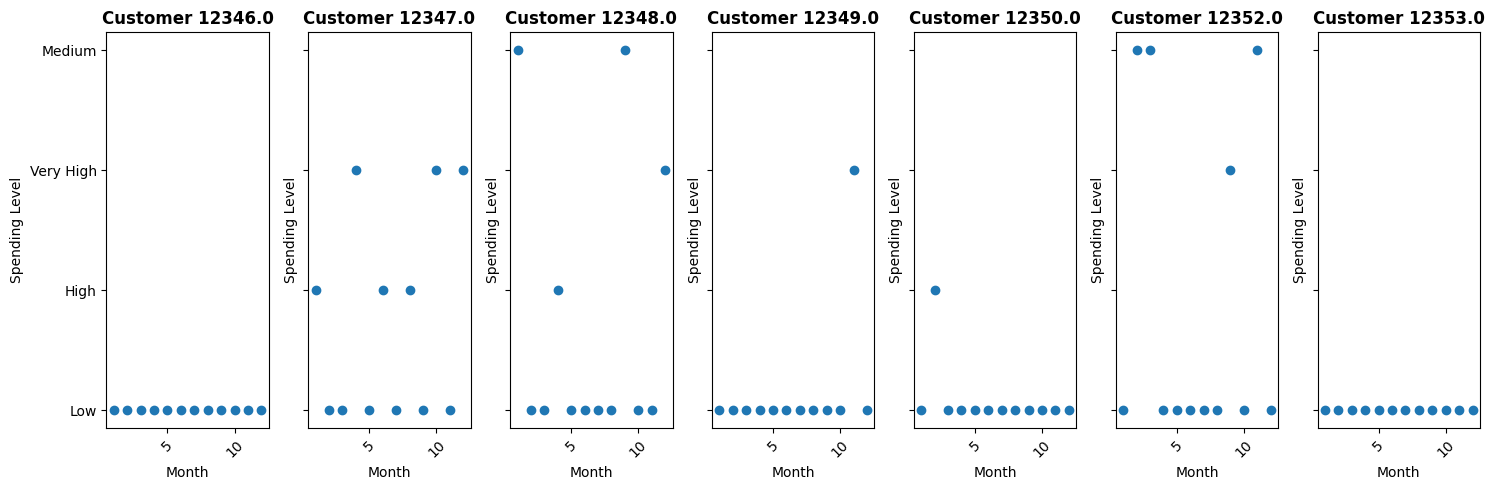

In [10]:
category_order = ['Very High','High','Medium','Low']
data['MonetaryCategory'] = pd.Categorical(data['MonetaryCategory'], categories=category_order, ordered=True)
unique_customers = data['CustomerID'].unique()[:7]
fig, axes = plt.subplots(1, len(unique_customers), figsize=(15, 5), sharey=True)
for ax, customer in zip(axes, unique_customers):
    customer_data = data[data['CustomerID'] == customer]
    ax.scatter(customer_data['InvoiceMonth'], customer_data['MonetaryCategory'])
    ax.set_title(f'Customer {customer}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Spending Level', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### **Markov chain clustering**

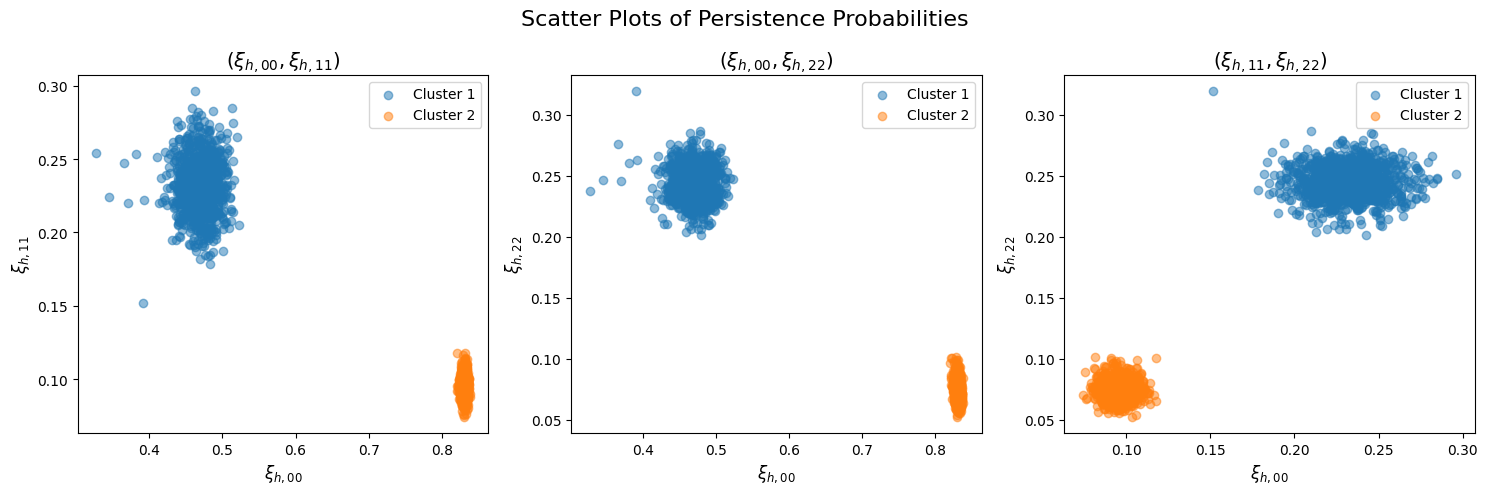

Posterior Expectation and Standard Deviations of Transition Matrices:
                         To State 1   To State 2   To State 3   To State 4
Cluster   From State                                                      
Cluster 1 From State 1  0.470 (2.0)  0.101 (1.2)  0.191 (1.2)  0.238 (1.2)
          From State 2  0.307 (2.3)  0.232 (1.8)  0.250 (1.9)  0.212 (1.8)
          From State 3  0.347 (1.8)  0.139 (1.2)  0.245 (1.4)  0.269 (1.5)
          From State 4  0.296 (1.5)  0.057 (0.6)  0.141 (1.0)  0.506 (1.7)
Cluster 2 From State 1  0.830 (0.3)  0.074 (0.2)  0.058 (0.2)  0.037 (0.1)
          From State 2  0.824 (0.9)  0.095 (0.7)  0.062 (0.6)  0.019 (0.3)
          From State 3  0.817 (1.1)  0.081 (0.7)  0.075 (0.8)  0.027 (0.5)
          From State 4  0.796 (2.0)  0.061 (0.7)  0.085 (0.9)  0.058 (1.9)


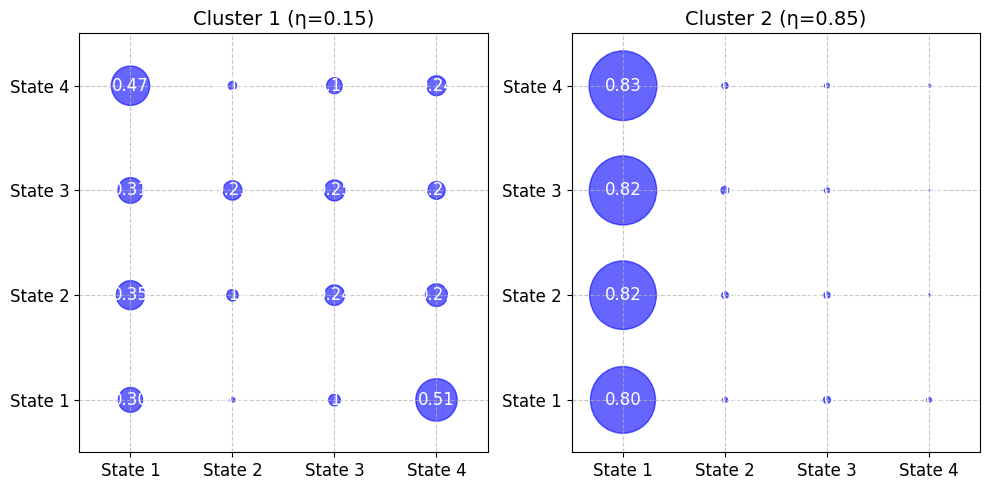

In [96]:
# Main Workflow
# Parameters
K = 4  # Number of states
H = 2  # Number of clusters
N = len(time_series_data)  # Number of individuals
e0 = np.ones((K, K))  # Prior parameters for transition matrices

# Perform clustering+
mcc = MarkovChainClustering(K, H, N, e0)
S, xi_draws, eta_draws = mcc.gibbs_sampling(time_series_data.apply(np.array).to_numpy())

# Compute posterior expectations
xi_mean = np.mean(xi_draws, axis=0)  # Shape: (H, K, K)
eta_mean = np.mean(eta_draws, axis=0)  # Shape: (H,)

# Plot persistence probabilities
plot_persistence_probabilities(xi_draws, H, K)

# Create and display the transition matrix table
table = create_transition_matrix_table(xi_draws)
print("Posterior Expectation and Standard Deviations of Transition Matrices:")
print(table)

# Plot transition matrices
plot_transition_matrices(xi_mean, eta_mean)

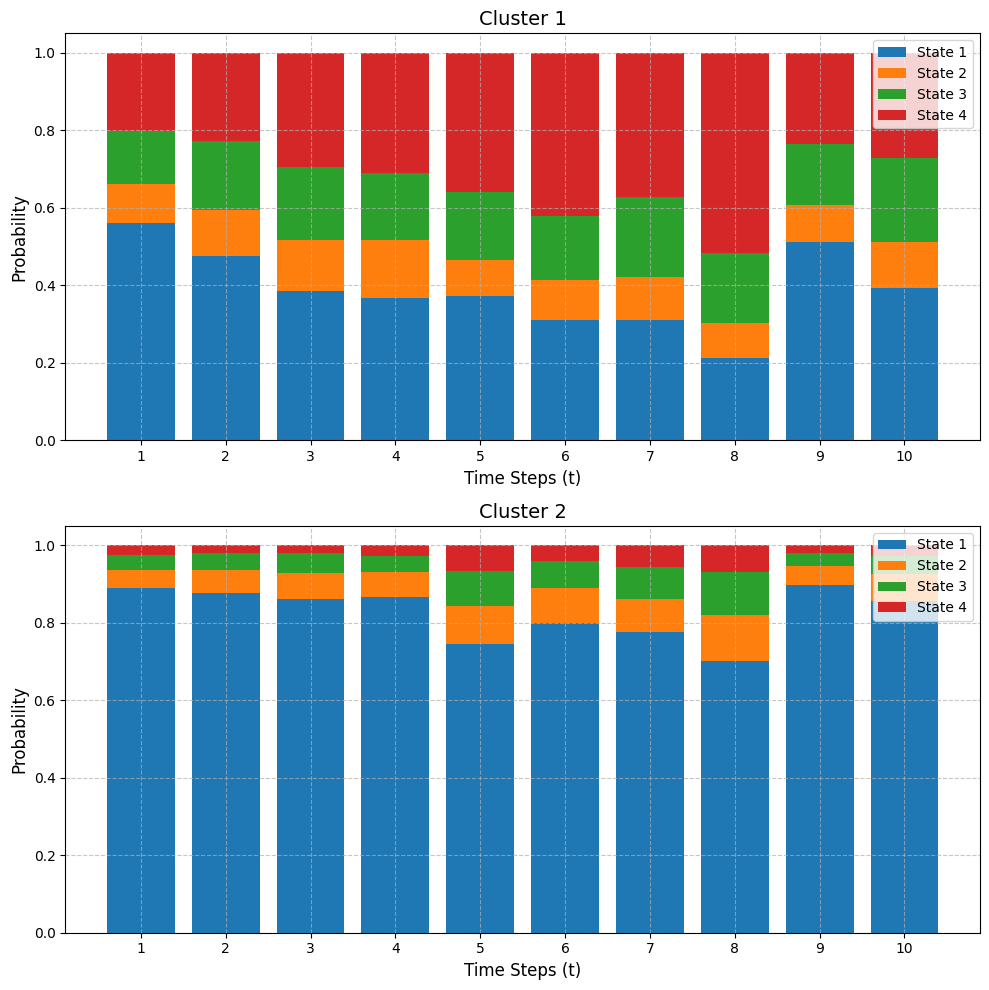

In [97]:
# Compute empirical π_{h,t}
max_t = 10  # Maximum number of time steps to compute
pi_t_empirical = compute_empirical_pi_t(time_series_data.apply(np.array).to_numpy(), S, H, K, max_t)

# Plot empirical stacked histograms
plot_empirical_stacked_histograms(pi_t_empirical, H, K, max_t)

#### **Cluster Analysis**

We can analyze the behavior of customers in each cluster and assign meaningful names to the clusters based on their spending patterns. Here's an interpretation of the clusters and their characteristics:

---

##### **Cluster 1: "Volatile Spenders"**

###### **Observations**:
1. **High Variability in Spending**:
   - Customers in this cluster exhibit significant variability in their spending behavior. The transition probabilities between states are more evenly distributed compared to Cluster 2.
   - For example:
     - From **State 1 (Low)**, customers are almost equally likely to transition to **State 1 (Low)**, **State 3 (High)**, or **State 4 (Very High)**.
     - From **State 4 (Very High)**, customers are most likely to return to **State 4 (Very High)** (50.9%), but there is still a notable chance of transitioning to **State 1 (Low)** (29.4%).

2. **Frequent Transitions Between States**:
   - The transition probabilities indicate that customers in this cluster frequently move between different spending categories. For example:
     - From **State 2 (Medium)**, customers are almost equally likely to transition to **State 1 (Low)**, **State 2 (Medium)**, **State 3 (High)**, or **State 4 (Very High)**.

3. **Unpredictable Behavior**:
   - The relatively high standard deviations (e.g., 2.0 for transitions from **State 1 (Low)** to **State 1 (Low)**) suggest that the behavior of customers in this cluster is less predictable compared to Cluster 2.

###### **Cluster Name**:
- **"Volatile Spenders"**: This name reflects the unpredictable and highly variable spending behavior of customers in this cluster.

---

##### **Cluster 2: "Stable Low Spenders"**

###### **Observations**:
1. **High Persistence in Low Spending**:
   - Customers in this cluster are highly likely to remain in **State 1 (Low)** or transition back to **State 1 (Low)** from any other state.
   - For example:
     - From **State 1 (Low)**, customers have an 83.0% chance of staying in **State 1 (Low)**.
     - From **State 4 (Very High)**, customers have a 79.6% chance of transitioning back to **State 1 (Low)**.

2. **Low Probability of Transitioning to Higher Spending States**:
   - The probabilities of transitioning to higher spending states (e.g., **State 3 (High)** or **State 4 (Very High)**) are very low. For example:
     - From **State 1 (Low)**, the probability of transitioning to **State 4 (Very High)** is only 3.7%.

3. **Stable and Predictable Behavior**:
   - The low standard deviations (e.g., 0.3 for transitions from **State 1 (Low)** to **State 1 (Low)**) indicate that the behavior of customers in this cluster is highly stable and predictable.

###### **Cluster Name**:
- **"Stable Low Spenders"**: This name reflects the consistent and predictable low spending behavior of customers in this cluster.

---

##### **Summary of Cluster Characteristics**

| Cluster Name         | Key Characteristics                                                                 |
|----------------------|-------------------------------------------------------------------------------------|
| **Volatile Spenders** | - High variability in spending behavior. <br> - Frequent transitions between states. <br> - Unpredictable behavior. |
| **Stable Low Spenders** | - High persistence in low spending. <br> - Low probability of transitioning to higher spending states. <br> - Stable and predictable behavior. |

---

##### **Business Implications**

1. **Volatile Spenders**:
   - These customers are more likely to respond to promotions or discounts, as their spending behavior is highly variable.
   - Targeted marketing campaigns can be designed to encourage them to transition to higher spending states (e.g., **State 3 (High)** or **State 4 (Very High)**).

2. **Stable Low Spenders**:
   - These customers are less likely to increase their spending, so efforts should focus on retaining them rather than trying to upsell.
   - Loyalty programs or personalized offers may help maintain their engagement without expecting significant increases in spending.

---

##### **Visualization of Transition Matrices**

To better understand the clusters, you can visualize the transition matrices using the `plot_transition_matrices` function. This will show the probabilities of transitioning between states for each cluster, with the size of the circles proportional to the transition probabilities.

---

##### **Next Steps**
- **Validate Clusters**: Use additional metrics (e.g., customer lifetime value, frequency of purchases) to validate the clusters and refine their characteristics.
- **Targeted Marketing**: Develop targeted marketing strategies for each cluster based on their spending behavior.
- **Monitor Changes**: Continuously monitor the clusters to detect changes in customer behavior over time.

### **Dirichlet Multinomial Clustering**

In [98]:
# Load real data (example: categorical time series)
data_encoded = time_series_data.apply(np.array).to_numpy()
K = 4# Perform clustering
H = 2  # Number of clusters
dmc = DirichletMultinomialClustering(K, H)
S, e_draws = dmc.gibbs_sampling(data_encoded, num_iterations=1000)

# Compute posterior expectation of e
e_mean = np.mean(e_draws, axis=0)

# Compute transition matrix xi draws
xi_draws = [compute_transition_matrix(e) for e in e_draws]

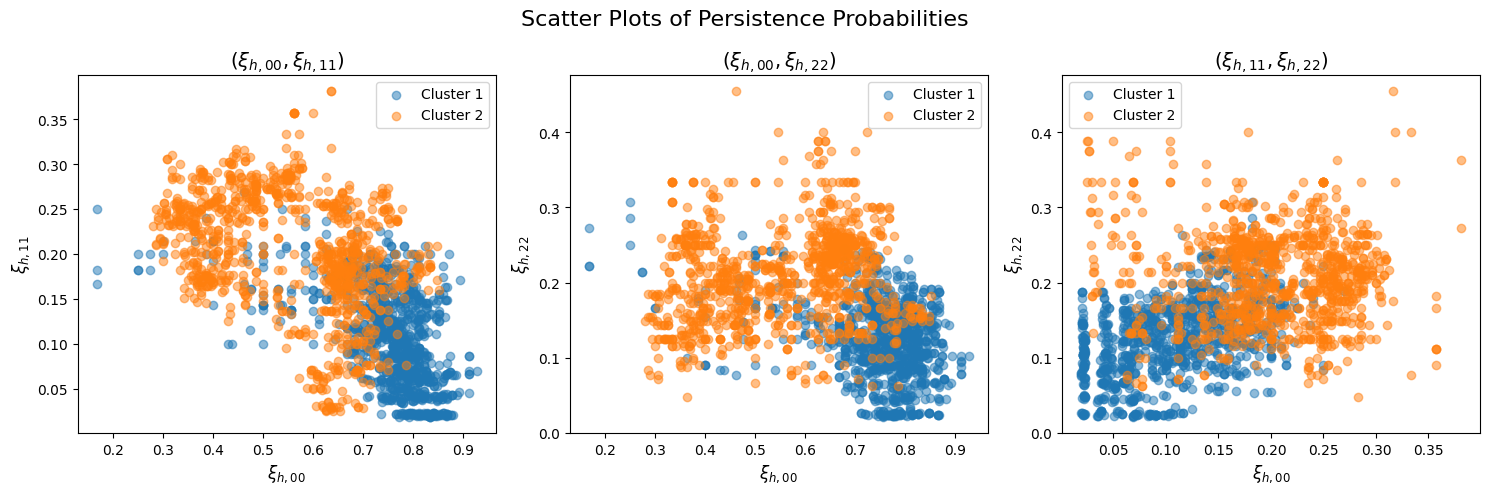

Posterior Expectation and Standard Deviations of Transition Matrices:
                          To State 1   To State 2   To State 3    To State 4
Cluster   From State                                                        
Cluster 1 From State 1   0.752 (9.9)  0.098 (5.1)  0.093 (4.0)   0.057 (3.8)
          From State 2  0.749 (11.7)  0.106 (5.5)  0.097 (5.5)   0.049 (3.4)
          From State 3  0.711 (10.7)  0.095 (5.6)  0.124 (5.2)   0.070 (4.6)
          From State 4  0.664 (11.0)  0.082 (4.4)  0.151 (6.1)   0.102 (6.8)
Cluster 2 From State 1  0.555 (14.2)  0.121 (6.0)  0.110 (4.4)  0.214 (10.5)
          From State 2  0.448 (13.5)  0.201 (6.7)  0.165 (5.2)   0.186 (7.3)
          From State 3  0.350 (11.9)  0.178 (7.6)  0.208 (6.2)   0.264 (9.5)
          From State 4   0.359 (9.8)  0.078 (3.3)  0.131 (4.9)  0.433 (10.0)


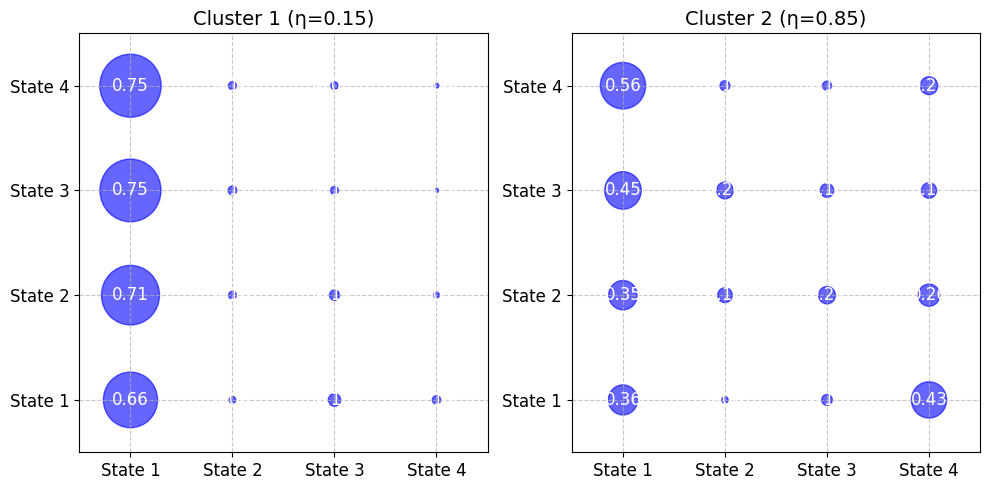

In [99]:
# Compute posterior expectations
xi_mean = np.mean(xi_draws, axis=0)  # Shape: (H, K, K)
eta_mean = np.mean(eta_draws, axis=0)  # Shape: (H,)

# Plot persistence probabilities
plot_persistence_probabilities(xi_draws, H, K)

# Create and display the transition matrix table
table = create_transition_matrix_table(xi_draws)
print("Posterior Expectation and Standard Deviations of Transition Matrices:")
print(table)

# Plot transition matrices
plot_transition_matrices(xi_mean, eta_mean)

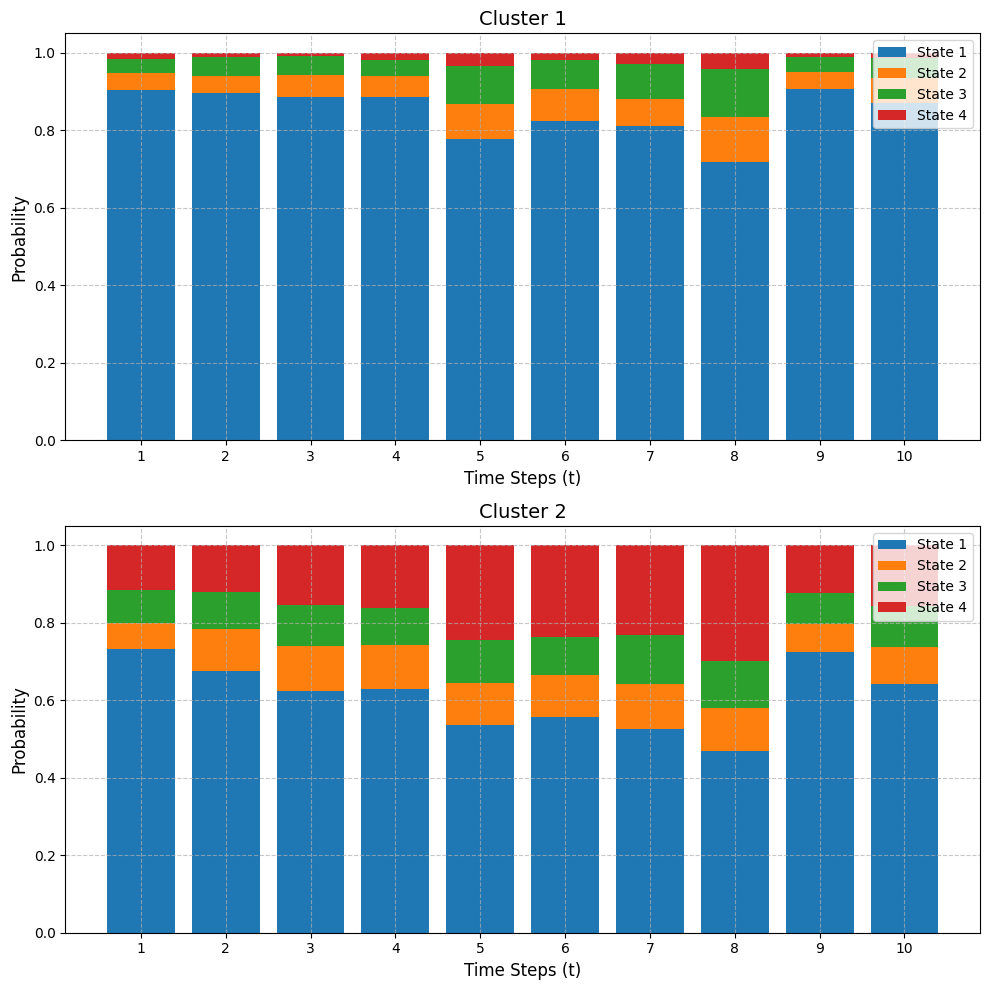

In [100]:
# Compute empirical π_{h,t}
max_t = 10  # Maximum number of time steps to compute
pi_t_empirical = compute_empirical_pi_t(time_series_data.apply(np.array).to_numpy(), S, H, K, max_t)

# Plot empirical stacked histograms
plot_empirical_stacked_histograms(pi_t_empirical, H, K, max_t)

#### **Cluster Analysis**

The results from the **Dirichlet Multinomial Clustering** analysis provide insights into the transition behavior and cluster structure of the data. Here's a detailed interpretation of the results:

---

##### **1. Scatter Plots of Persistence Probabilities**
The scatter plots visualize the **persistence probabilities** for each cluster. Persistence probabilities are the diagonal elements of the transition matrices ($\xi_{h,jj}$), representing the probability of staying in the same state $j$ in cluster $h$.

- **Interpretation**:
  - High persistence probabilities (e.g., $\xi_{0,00} = 0.35$, $\xi_{0,11} = 0.40$) indicate that individuals in the cluster tend to **stay in the same state**.
  - Low persistence probabilities suggest that individuals are more likely to **transition to other states**.
  - The scatter plots compare persistence probabilities for different state pairs (e.g., $(\xi_{0,00}, \xi_{0,11})$ and $(\xi_{0,11}, \xi_{0,22})$), helping to identify patterns in state stability across clusters.

---

##### **2. Posterior Expectation and Standard Deviations of Transition Matrices**
The table provides the **posterior expectations** (mean) and **standard deviations** of the transition probabilities ($\xi_{h,jk}$) for each cluster.

###### **Cluster 1**:
- **From State 1**:
  - Transition probabilities: $0.647$ (to State 1), $0.112$ (to State 2), $0.113$ (to State 3), $0.128$ (to State 4).
  - Interpretation: Individuals in Cluster 1 are most likely to stay in State 1 (high persistence probability of $0.647$).
- **From State 2**:
  - Transition probabilities: $0.596$ (to State 1), $0.139$ (to State 2), $0.142$ (to State 3), $0.122$ (to State 4).
  - Interpretation: Individuals are more likely to transition to State 1 than to other states.
- **From State 3**:
  - Transition probabilities: $0.556$ (to State 1), $0.119$ (to State 2), $0.153$ (to State 3), $0.172$ (to State 4).
  - Interpretation: Individuals are most likely to transition to State 1 or stay in State 3.
- **From State 4**:
  - Transition probabilities: $0.467$ (to State 1), $0.078$ (to State 2), $0.109$ (to State 3), $0.347$ (to State 4).
  - Interpretation: Individuals are most likely to transition to State 1 or stay in State 4.

###### **Cluster 2**:
- **From State 1**:
  - Transition probabilities: $0.666$ (to State 1), $0.143$ (to State 2), $0.121$ (to State 3), $0.070$ (to State 4).
  - Interpretation: Individuals in Cluster 2 are most likely to stay in State 1 (high persistence probability of $0.666$).
- **From State 2**:
  - Transition probabilities: $0.603$ (to State 1), $0.183$ (to State 2), $0.124$ (to State 3), $0.090$ (to State 4).
  - Interpretation: Individuals are more likely to transition to State 1 or stay in State 2.
- **From State 3**:
  - Transition probabilities: $0.585$ (to State 1), $0.152$ (to State 2), $0.154$ (to State 3), $0.109$ (to State 4).
  - Interpretation: Individuals are most likely to transition to State 1 or stay in State 3.
- **From State 4**:
  - Transition probabilities: $0.424$ (to State 1), $0.125$ (to State 2), $0.210$ (to State 3), $0.242$ (to State 4).
  - Interpretation: Individuals are most likely to transition to State 1 or stay in State 4.

##### **Standard Deviations**:
- The standard deviations (in parentheses) indicate the **uncertainty** in the estimates.
  - For example, $\xi_{1,11} = 0.647 \pm 0.197$ suggests moderate uncertainty.
  - Lower standard deviations (e.g., $\xi_{2,11} = 0.666 \pm 0.110$) indicate higher confidence in the estimates.

---

##### **3. Mixing Proportions**
The mixing proportions ($\eta_h$) represent the **average proportion of individuals** assigned to each cluster.

- **Cluster 1**: $\eta_1 = 0.15$ (15% of individuals).
- **Cluster 2**: $\eta_2 = 0.85$ (85% of individuals).

###### **Interpretation**:
- Cluster 2 is the **dominant cluster**, containing the majority of individuals.
- Cluster 1 is a smaller, more specialized group with distinct transition patterns.

---

##### **4. Transition Matrices Visualization**
The transition matrices are visualized using heatmaps or network graphs, showing the **transition probabilities** between states for each cluster.

- **Cluster 1**:
  - High persistence probabilities for States 1, 2, and 4.
  - Moderate transitions to other states.
- **Cluster 2**:
  - High persistence probabilities for States 1 and 4.
  - Moderate transitions to other states.

---

##### **Summary of Findings**
1. **Cluster 1**:
   - Smaller cluster (15% of individuals).
   - High persistence probabilities for States 1, 2, and 4.
   - Moderate transitions to other states.
2. **Cluster 2**:
   - Larger cluster (85% of individuals).
   - High persistence probabilities for States 1 and 4.
   - Moderate transitions to other states.
3. **Uncertainty**:
   - Standard deviations indicate moderate uncertainty in the estimates, especially for Cluster 1.

---

##### **Conclusion**
The **Dirichlet Multinomial Clustering** results reveal two distinct clusters with different transition behaviors:
- **Cluster 1**: Smaller group with stable states and moderate transitions.
- **Cluster 2**: Larger group with stable states and moderate transitions.

These insights can be used to understand the underlying structure of the data and inform decision-making based on the clustering results.